In [1]:
import qiskit
from qutip import Qobj, tensor, ptrace
import qiskit_aer
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_experiments.library import StateTomography
from qiskit.quantum_info import DensityMatrix

In [2]:
def evolve_basic(g, dt, N):
    
    circ = qiskit.QuantumCircuit(N)
    
    x_angle = - dt * g

    z_angle = - dt
    
    
    #e^B
    for i in range(int(N/2-1)):
        circ.rzz(z_angle, 2*i+1, 2*i+2) # z rotation
        
    for i in range(int(N/2)):
        circ.rzz(z_angle, 2*i, 2*i+1) # z rotation
           
    #e^A        
    for i in range(N):
        circ.rx(x_angle, i) # x rotation
    
    
    return circ

In [3]:
def evolve_symmetric(g, dt, N):
    
    circ = qiskit.QuantumCircuit(N)
    
    x_angle = - dt * g

    z_angle = - dt
    
    for i in range(N):
        
        circ.rx(x_angle/2, i) # x rotation
        
        
    for i in range(int(N/2-1)):
        
        circ.rzz(z_angle, 2*i+1, 2*i+2) # z rotation
        
    for i in range(int(N/2)):
        
        circ.rzz(z_angle, 2*i, 2*i+1) # z rotation
        
    for i in range(N):
        
        circ.rx(x_angle/2, i) # x rotation
        
    return circ

In [4]:
def partial_trace(rho):

    keep = list(range(5, 10))
    
    rho_reduced = ptrace(rho, keep)
    
    numpy = rho_reduced.full()
    
    return numpy


def von_neumann_entropy(rho):
    
    # Compute eigenvalues of rho
    eigenvalues = np.linalg.eigvalsh(rho)
    
    # Filter out zero eigenvalues to avoid log(0)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy
    S = -np.sum(non_zero_eigenvalues * np.log(non_zero_eigenvalues))
    
    return S


def renyi2_entropy(rho):
    
    # Compute rho^2
    rho_squared = np.dot(rho, rho)
    
    # Compute the trace of rho^2
    trace_rho_squared = np.trace(rho_squared)
    
    # Compute Rényi entropy of order 2
    S2 = -np.log(trace_rho_squared)
    
    return S2


In [5]:
#entropy

N = 10
g = 2 
t = 5
dt = 0.1
array_size = int(t/dt)

mt = np.zeros(array_size)
S = np.zeros(array_size)
S2 = np.zeros(array_size)

Evolve_Basic = evolve_symmetric(g, dt, N)


for i in range(array_size):
    
    combined = qiskit.QuantumCircuit(N)
    for j in range(i):
        combined = combined.compose(Evolve_Basic)
        
    combined.measure_all()
    sim = AerSimulator()
    shot = 20
    
    result = sim.run(combined, shots = shot).result().get_counts()

    total = 0

    # Iterate through the dictionary items
    for binary_str, count in result.items():
        # Count the number of ones in the binary string
        num_zeros = binary_str.count('0')
        # Multiply the count of ones by the histogram count
        total += (2*num_zeros - N) * count
    mt[i] = total / shot / N

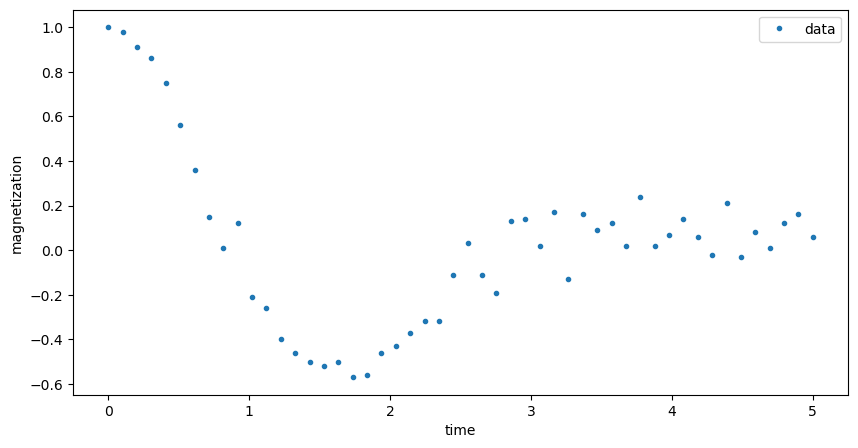

In [6]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(np.linspace(0, t, array_size), mt, '.', label='data') 
plt.xlabel('time')
plt.ylabel('magnetization')
plt.legend()
plt.show()

In [9]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)

S = np.zeros(array_size)
S2 = np.zeros(array_size)

Evolve_Basic = evolve_symmetric(g, dt, N)

#sim = AerSimulator()

for i in range(array_size):

    combined = qiskit.QuantumCircuit(N)
    
    for j in range(i+1):
        combined = combined.compose(Evolve_Basic)
        
    combined.save_statevector()
    sim = AerSimulator()
    result = sim.run(combined).result()
    psi = result.get_statevector()
    
    psi = psi / np.linalg.norm(psi)
    
    rho = np.outer(psi.conjugate(), psi) 
    
    qobj = Qobj(rho, dims=[[2]*N, [2]*N]) #partial trace take input qobj object
    
    Rho = partial_trace(qobj) #output np matrix

    S[i] = von_neumann_entropy(Rho)
    S2[i] = np.real(renyi2_entropy(Rho))

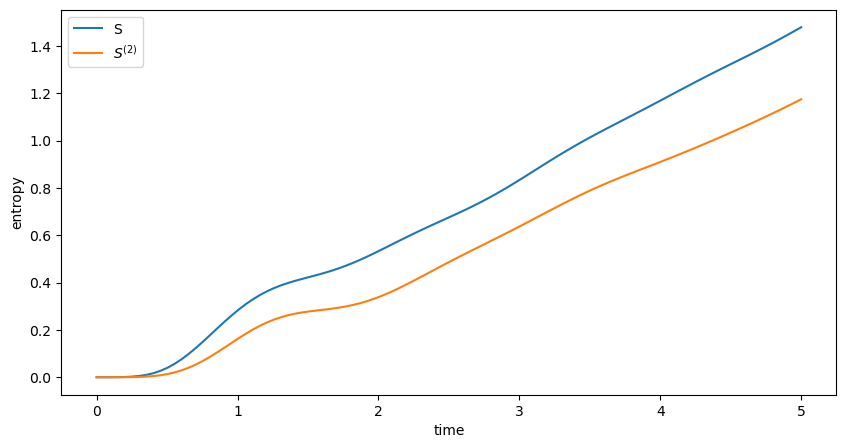

In [11]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(np.linspace(0, t, array_size), S, label='S') 
ax.plot(np.linspace(0, t, array_size), S2, label='$S^{(2)}$')
plt.xlabel('time')
plt.ylabel('entropy')
plt.legend()
#plt.savefig("plt_es11sy.pdf")
plt.show()

In [12]:
N = 10
g = 2 
t = 5
dt = 0.05
array_size = int(t/dt)

S = np.zeros(array_size)
S2 = np.zeros(array_size)

Evolve_Basic = evolve_basic(g, dt, N)

for i in range(array_size):

    combined = qiskit.QuantumCircuit(N)
    
    for j in range(i+1):
        combined = combined.compose(Evolve_Basic)
        
    combined.save_statevector()
    sim = AerSimulator()
    result = sim.run(combined).result()
    psi = result.get_statevector()
    
    psi = psi / np.linalg.norm(psi)
    
    rho = np.outer(psi.conjugate(), psi) 
    
    qobj = Qobj(rho, dims=[[2]*N, [2]*N]) #partial trace take input qobj object
    
    Rho = partial_trace(qobj) #output np matrix

    S[i] = von_neumann_entropy(Rho)
    S2[i] = np.real(renyi2_entropy(Rho))

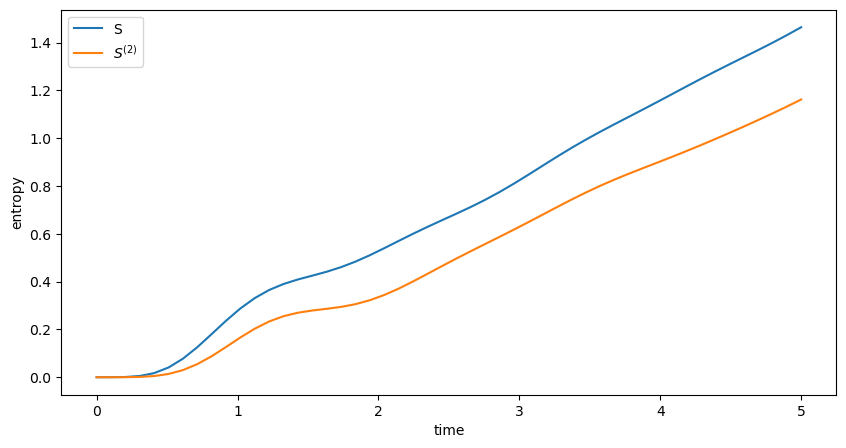

In [15]:
fig, ax = plt.subplots(1,figsize=(10,5))
ax.plot(np.linspace(0, t, array_size), S, label='S') 
ax.plot(np.linspace(0, t, array_size), S2, label='$S^{(2)}$')
plt.xlabel('time')
plt.ylabel('entropy')
plt.legend()
plt.savefig("plt_es11bas.pdf")
plt.show()

In [ ]:
##es12

In [ ]:
N = 10
g = 2 
t = 5
dt = 0.1
array_size = int(t/dt)
tomo_rep=400

S = np.zeros(array_size)
S2 = np.zeros(array_size)

Evolve_Basic = evolve_basic(g, dt, N)
sim = AerSimulator()


for i in range(array_size):

    combined = qiskit.QuantumCircuit(N)
    
    for j in range(i+1):
        combined = combined.compose(Evolve_Basic)
        
    
    tomo = StateTomography(combined)
    
    print(i)
    
    expdata = tomo.run(sim, seed_simulation=400).block_for_results()

    rho_fit = expdata.analysis_results("state").value
    
    rho_fit=np.array(rho_fit)
    
    print(np.size(rho_fit))
    print((2**N)**2)
    
    
    #qobj = Qobj(rho_fit, dims=[[2]*N, [2]*N]) #partial trace take input qobj object
    
    #Rho = partial_trace(qobj) #output np matrix

    #S[i] = von_neumann_entropy(Rho)
    #S2[i] = np.real(renyi2_entropy(Rho))
    

In [ ]:
import qiskit
from qiskit_experiments.library import StateTomography

N = 5
g = 2 
t = 5
dt = 0.1
array_size = int(t/dt)
tomo_rep=400

# GHZ State preparation circuit
nq = 5
#qc_ghz = qiskit.QuantumCircuit(nq)
qc_ghz = evolve_basic(g, dt, N)
sim = AerSimulator()

print(1)

qstexp1 = StateTomography(qc_ghz)
qstdata1 = qstexp1.run(sim, shots = 100, seed_simulation=400).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)
    
state_result = qstdata1.analysis_results("state")

print('eigvals=', state_result.extra['eigvals'])